In [1]:
import json
from selenium import webdriver
import sqlite3
import pandas as pd

with open('env_keys.json') as infile:
    env_variables = json.load(infile)

from BeerMe import data_extractors

In [2]:
db_path = 'beer.db'

In [3]:
conn = sqlite3.connect(db_path)
query = 'SELECT * FROM user_extract'
df = pd.read_sql(query,conn)

In [4]:
df.head()

,username,beer_name,beer_description,brewery,ABV,IBU,global_rating,user_rating,first_date,recent_date,total
0,tnt,Society & Solitude #7,IPA - Imperial / Double,Hill Farmstead Brewery,8.0,None,4.38,4.25,06/17/19,06/17/19,1
1,tnt,Riwaka Single Hop Pale Ale,Pale Ale - American,Hill Farmstead Brewery,5.2,None,4.14,5.00,06/17/19,06/17/19,1
2,tnt,"Walk, Don't Run",Blonde Ale,Suarez Family Brewery,3.7,None,4.10,4.50,06/17/19,06/17/19,1
3,tnt,Czech Two,Pilsner - Czech,Gravely Brewing Co,4.1,39,3.81,4.25,06/17/19,06/17/19,1
4,tnt,Spirit of Revolt,IPA - Imperial / Double,Revolution Brewing Company,8.2,52,3.82,4.00,06/08/19,06/08/19,1


## Select User with Most Check-Ins

In [5]:
top_checkins = df.groupby('username').count()['total'].reset_index().sort_values('total', ascending=False)

In [6]:
top_checkins.head()

,username,total
14,Nitro13,3400
18,RudyCptn93,2575
6,JustinX03,2325
19,SestervikensBryggeri_Lars,1874
37,marcusSRG,1750


In [7]:
nitro = df[df['username'] == 'Nitro13']
nitro.head()

,username,beer_name,beer_description,brewery,ABV,IBU,global_rating,user_rating,first_date,recent_date,total
18433,Nitro13,Humdinger,IPA - New England,Norbrook Farm Brewery,7.5,45,3.81,4.0,06/22/19,06/22/19,1
18434,Nitro13,Beckley Furnace Ale,Brown Ale - American,Norbrook Farm Brewery,6.0,20,3.79,4.0,06/22/19,06/22/19,1
18435,Nitro13,Bière De Fermes,Bière de Garde,Norbrook Farm Brewery,6.2,20,3.87,3.0,06/22/19,06/22/19,1
18436,Nitro13,Lucky Day,IPA - American,Norbrook Farm Brewery,7.0,42,3.65,3.5,06/22/19,06/22/19,1
18437,Nitro13,Cog Ale,Kölsch,Norbrook Farm Brewery,4.7,17,3.66,4.0,06/22/19,06/22/19,1


In [8]:
x = nitro[['beer_description', 'brewery', 'ABV', 'IBU', 'global_rating', 'total']]
y = nitro['user_rating']

## Export

In [32]:
x_raw = x
y_raw = y

x.to_csv("x_raw.csv")
y.to_csv("y_raw.csv")

C:\Users\tomsharp\AppData\Local\Continuum\miniconda3\envs\ml_guild\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


## Preprocessing

### Dummy Variables

Descriptions

In [9]:
description_dummies = pd.get_dummies(x['beer_description'])

In [10]:
description_dummies.sum().sort_values(ascending=False).head(15)

IPA - American                        611
IPA - Imperial / Double               330
Pale Ale - American                   191
IPA - New England                     167
IPA - Session / India Session Ale     100
Brown Ale - American                   78
Stout - American Imperial / Double     72
Porter - American                      72
Farmhouse Ale - Saison                 67
Stout - Oatmeal                        62
Porter - Other                         61
Stout - Milk / Sweet                   60
Stout - American                       56
Red Ale - American Amber / Red         56
Pumpkin / Yam Beer                     56
dtype: int64

In [11]:
# consolidate dummies, write new col to x
description_names = description_dummies.sum()[description_dummies.sum() >= 100].index.tolist()
x['description_consolidated'] = [val if val in description_names else 'Other' for val in x['beer_description']]

# drop Other, replace variables with dummies
description_dummies = pd.get_dummies(x['description_consolidated']).drop('Other', axis=1)

C:\Users\tomsharp\AppData\Local\Continuum\miniconda3\envs\ml_guild\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
x = pd.merge(x, description_dummies, left_index=True, right_index=True)
x = x.drop(['beer_description', 'description_consolidated'], axis=1)
x.head()

,brewery,ABV,IBU,global_rating,total,IPA - American,IPA - Imperial / Double,IPA - New England,IPA - Session / India Session Ale,Pale Ale - American
18433,Norbrook Farm Brewery,7.5,45,3.81,1,0,0,1,0,0
18434,Norbrook Farm Brewery,6.0,20,3.79,1,0,0,0,0,0
18435,Norbrook Farm Brewery,6.2,20,3.87,1,0,0,0,0,0
18436,Norbrook Farm Brewery,7.0,42,3.65,1,1,0,0,0,0
18437,Norbrook Farm Brewery,4.7,17,3.66,1,0,0,0,0,0


Breweries

In [13]:
brewery_dummies = pd.get_dummies(x['brewery'])

In [14]:
brewery_dummies.sum().sort_values(ascending=False).head(50)
brewery_dummies.sum().hist(bins=100)

In [15]:
# consolidate dummies, write new col to x
brewery_names = brewery_dummies.sum()[brewery_dummies.sum() > 10].index.tolist()
x['brewery_consolidated'] = [val if val in brewery_names else 'Other' for val in x['brewery']]

# drop Other, replace variables with dummies
brewery_dummies = pd.get_dummies(x['brewery_consolidated']).drop('Other', axis=1)

In [16]:
x = pd.merge(x, brewery_dummies, left_index=True, right_index=True)
x = x.drop(['brewery', 'brewery_consolidated'], axis=1)

In [17]:
x.head()

,ABV,IBU,global_rating,total,IPA - American,IPA - Imperial / Double,IPA - New England,IPA - Session / India Session Ale,Pale Ale - American,30 Mile Brewing Co.,...,SweetWater Brewing Company,Thimble Island Brewing Company,Thomas Hooker Brewing Co.,Top Shelf Brewing Company,Tree House Brewing Company,Trillium Brewing Company,Tröegs Independent Brewing,Two Roads Brewing Company,Veracious Brewing Company,Wicked Weed Brewing
18433,7.5,45,3.81,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18434,6.0,20,3.79,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18435,6.2,20,3.87,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18436,7.0,42,3.65,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18437,4.7,17,3.66,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Missing Values and Types

In [18]:
x.isna().sum().head(5)

ABV                 57
IBU               1367
global_rating        0
total                0
IPA - American       0
dtype: int64

In [19]:
x['ABV'] = x['ABV'].fillna(x['ABV'].mean())

In [20]:
import numpy as np
x['IBU'].fillna(value=np.nan, inplace=True)
x['IBU'].replace('None', np.nan, inplace=True)

x['IBU'].fillna(value='drop', inplace=True)

ibu_mean = x[x['IBU'].fillna('drop') != 'drop']['IBU'].astype('int').mean()
x['IBU'].replace('drop',ibu_mean, inplace=True)

In [21]:
x['IBU'] = x['IBU'].astype('float')
x.dtypes

ABV                                        float64
IBU                                        float64
global_rating                              float64
total                                        int64
IPA - American                               uint8
IPA - Imperial / Double                      uint8
IPA - New England                            uint8
IPA - Session / India Session Ale            uint8
Pale Ale - American                          uint8
30 Mile Brewing Co.                          uint8
ARMADA BREWING                               uint8
Alvarium Beer Company                        uint8
Aspetuck Brew Lab                            uint8
BAD SONS Beer Co.                            uint8
Back East Brewing Company                    uint8
Ballast Point Brewing Company                uint8
Barrier Brewing Company                      uint8
Beer'd Brewing Company                       uint8
Big Elm Brewing                              uint8
Black Hog Brewing Co.          

In [22]:
x.isna().sum().head(5)

ABV               0
IBU               0
global_rating     0
total             0
IPA - American    0
dtype: int64

In [23]:
y.fillna(y.mean(),inplace=True)

C:\Users\tomsharp\AppData\Local\Continuum\miniconda3\envs\ml_guild\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [24]:
y.isna().any()

False

## Remove Outliers

## EDA

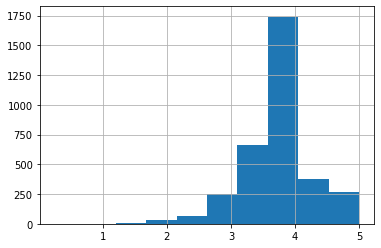

In [25]:
y.hist()

In [26]:
x.iloc[:,:4].corr()

,ABV,IBU,global_rating,total
ABV,1.000000,0.361751,0.297818,0.009177
IBU,0.361751,1.000000,0.179710,0.054792
global_rating,0.297818,0.179710,1.000000,0.092721
total,0.009177,0.054792,0.092721,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000173BCE4B048>,
      dtype=object)

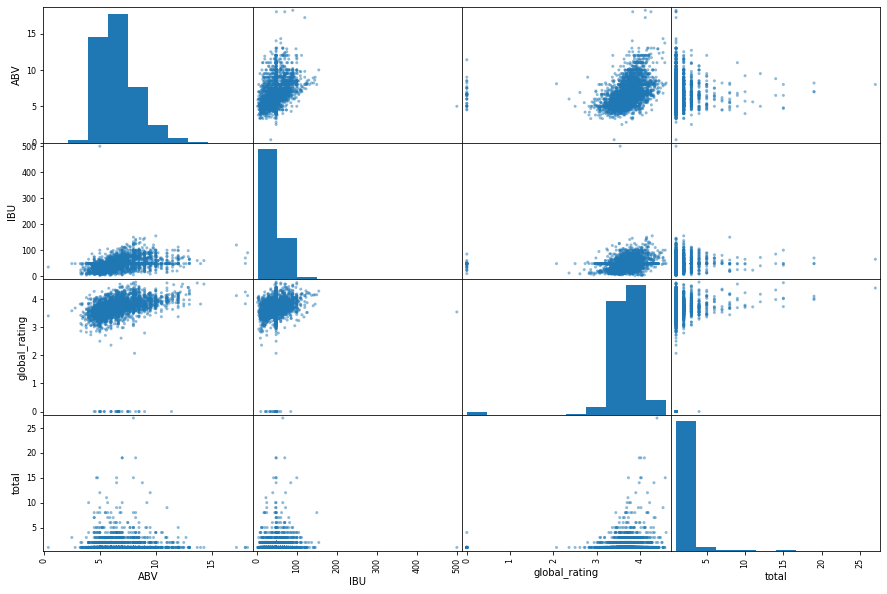

In [27]:
pd.plotting.scatter_matrix(x.iloc[:,:4], figsize=(15,10))

## Scaling

In [28]:
x.iloc[:,:4]

,ABV,IBU,global_rating,total
18433,7.50000,45.000000,3.81,1
18434,6.00000,20.000000,3.79,1
18435,6.20000,20.000000,3.87,1
18436,7.00000,42.000000,3.65,1
18437,4.70000,17.000000,3.66,1
18438,5.80000,30.000000,3.77,1
18439,8.20000,20.000000,3.88,1
18440,4.80000,25.000000,3.67,1
18441,6.80000,40.000000,4.06,1
18442,5.40000,17.000000,3.78,1


In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x.iloc[:,:4])
scaled = scaler.transform(x.iloc[:,:4])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000173C5961240>,
      dtype=object)

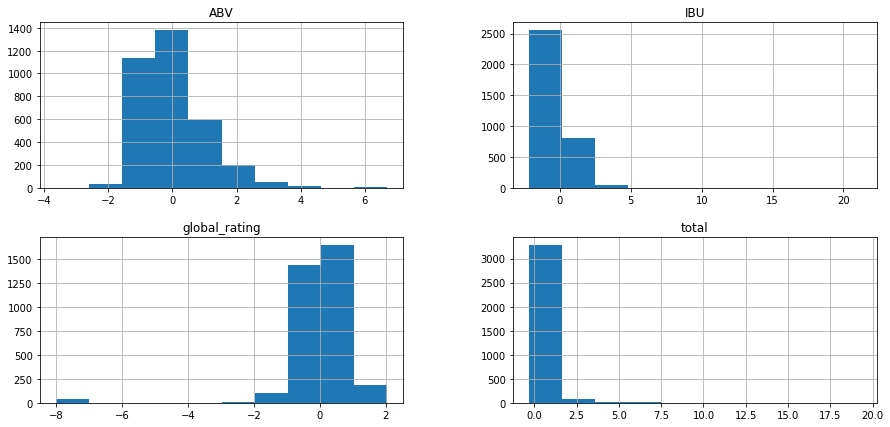

In [30]:
pd.DataFrame(scaled, columns=x.iloc[:,:4].columns).hist(figsize=(15,7))

In [31]:
x.iloc[:,:4] = scaled

## Modeling

In [212]:
from sklearn.linear_model import Lasso

lasso = Lasso()

lasso.fit(x,y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [216]:
predictions = lasso.predict(x)

In [220]:
results_df = pd.DataFrame([predictions,y]).transpose()
results_df.columns = ['prediction', 'actual']

In [221]:
results_df['error'] = results_df['prediction'] - results_df['actual']

In [237]:
avg_error = np.mean(results_df['error'])
std_error = np.std(results_df['error'])
print('avg error', avg_error, 
      '\n'
      'std of error', std_error)

avg error 3.646756099709926e-16 
std of error 0.5680579393827215


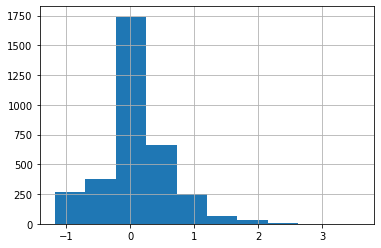

In [238]:
results_df['error'].hist()

In [227]:
rmse = np.sqrt(np.mean(results_df['error']**2))
rmse

0.5680579393827215

In [243]:
# iterate
alphas = np.linspace(0,1)

rmse_dict = {}
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(x,y)
    predictions = lasso.predict(x)
    
    errors = predictions - y
    rmse = np.sqrt(np.mean(errors**2))
    rmse_dict[a] = rmse

C:\Users\tomsharp\AppData\Local\Continuum\miniconda3\envs\ml_guild\lib\site-packages\ipykernel_launcher.py:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  import sys
C:\Users\tomsharp\AppData\Local\Continuum\miniconda3\envs\ml_guild\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\tomsharp\AppData\Local\Continuum\miniconda3\envs\ml_guild\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482.11600601999197, tolerance: 0.10971453964855282
  positive)


In [260]:
pd.DataFrame.from_dict(rmse_dict, orient='index').reset_index()

,index,0
0,0.000000,0.532539
1,0.020408,0.548936
2,0.040816,0.552443
3,0.061224,0.554364
4,0.081633,0.556987
5,0.102041,0.560342
6,0.122449,0.564415
7,0.142857,0.568058
8,0.163265,0.568058
9,0.183673,0.568058


In [261]:
lasso.coef_

array([-0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0., -0., -0.,
       -0.,  0., -0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,
       -0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0., -0., -0., -0., -0.,
        0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0., -0., -0.,  0., -0.,  0., -0., -0.,  0., -0., -0., -0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0., -0.,
       -0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.])